In [13]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pyfolio as pf
import warnings 
warnings.simplefilter('ignore')

### Adaptive Asset Allocation (AAA) Strategy: Detailed Methodology

The Adaptive Asset Allocation (AAA) strategy, as described in the paper "Adaptive Asset Allocation: A Primer" by Adam Butler, Michael Philbrick, Rodrigo Gordillo, and David Varadi, focuses on dynamically adjusting asset allocations based on recent performance, volatility, and correlations to optimize returns while managing risk. Here's a detailed explanation of the strategy's methodology.

#### 1. Asset Selection

The AAA strategy includes a diversified set of asset classes to capture different risk and return profiles. The typical investment universe comprises:

- **Equities**: Domestic and international stocks (e.g., SPY, EEM, VGK, EWJ)
- **Fixed Income**: Bonds (e.g., IEF, TLT)
- **Commodities**: Raw materials and natural resources (e.g., DBC, GLD)
- **Real Estate**: Real estate investment trusts (REITs) (e.g., VNQ, RWX)
- **Cash**: Cash equivalents like Treasury bills (e.g., BIL)

#### 2. Return Calculation

The strategy uses trailing returns over a specific period (e.g., 6 months) to evaluate the performance of each asset. The return of asset $ i $ over period $ t $ is given by:

$ R_{i,t} = \frac{P_{i,t} - P_{i,t-1}}{P_{i,t-1}} $

For trailing returns over \( T \) periods (e.g., 6 months), we use:

$ R_{i,t}^{(T)} = \frac{P_{i,t}}{P_{i,t-T}} - 1 $

#### 3. Volatility and Correlation Measurement

Risk is measured by the standard deviation of returns, providing a volatility estimate. Let $ \sigma_{i,t}^{(T)} $ be the standard deviation of the returns of asset $ i $ over the trailing period $ T $:

$ \sigma_{i,t}^{(T)} = \sqrt{\frac{1}{T} \sum_{k=1}^{T} \left( R_{i,t-k} - \bar{R}_{i,t}^{(T)} \right)^2} $

where $ \bar{R}_{i,t}^{(T)} $ is the mean return over the period $ T $:

$ \bar{R}_{i,t}^{(T)} = \frac{1}{T} \sum_{k=1}^{T} R_{i,t-k} $

Correlations between assets are also considered to ensure diversification. The correlation between assets $ i $ and $ j $ over period $ T $ is given by:

$ \rho_{i,j}^{(T)} = \frac{\sum_{k=1}^{T} \left( R_{i,t-k} - \bar{R}_{i,t}^{(T)} \right) \left( R_{j,t-k} - \bar{R}_{j,t}^{(T)} \right)}{\sqrt{\sum_{k=1}^{T} \left( R_{i,t-k} - \bar{R}_{i,t}^{(T)} \right)^2 \sum_{k=1}^{T} \left( R_{j,t-k} - \bar{R}_{j,t}^{(T)} \right)^2}} $

#### 4. Allocation Adjustment

The strategy adjusts allocations based on the trailing returns and volatility of each asset:

1. **Monthly Evaluation**: On the last trading day of the month, calculate the 6-month total return of the assets.
2. **Select Top Performers**: Invest in the five assets with the highest 6-month return.
3. **Weight by Volatility and Correlation**: The five selected assets are weighted in the portfolio according to their 6-month correlation and 1-month volatility.

The allocation $ w_{i,t} $ for each asset is determined as follows:

$ w_{i,t} = \frac{\frac{1}{\sigma_{i,t}}}{\sum_{j=1}^{N} \frac{1}{\sigma_{j,t}}} $

#### 5. Portfolio Rebalancing

- **Monthly Rebalancing**: The portfolio is rebalanced monthly to maintain the desired allocations based on updated performance and risk metrics.
- **Continuous Adjustment**: The portfolio adjusts dynamically to changing market conditions, ensuring it remains resilient and optimized for current risks and opportunities.

### Summary

The Adaptive Asset Allocation strategy involves:

- **Selecting a diversified set of asset classes** to capture a broad spectrum of risks and returns.
- **Calculating trailing returns and risk metrics** (volatility and correlation) to assess the performance and risk of each asset.
- **Adjusting asset allocations dynamically** based on recent performance, volatility, and correlations to optimize the risk-return profile.
- **Rebalancing the portfolio monthly** to ensure it remains aligned with the strategy's objectives.

This methodology aims to enhance returns while managing risk, adapting to changing market conditions to deliver more resilient portfolio performance.


[*********************100%%**********************]  10 of 10 completed


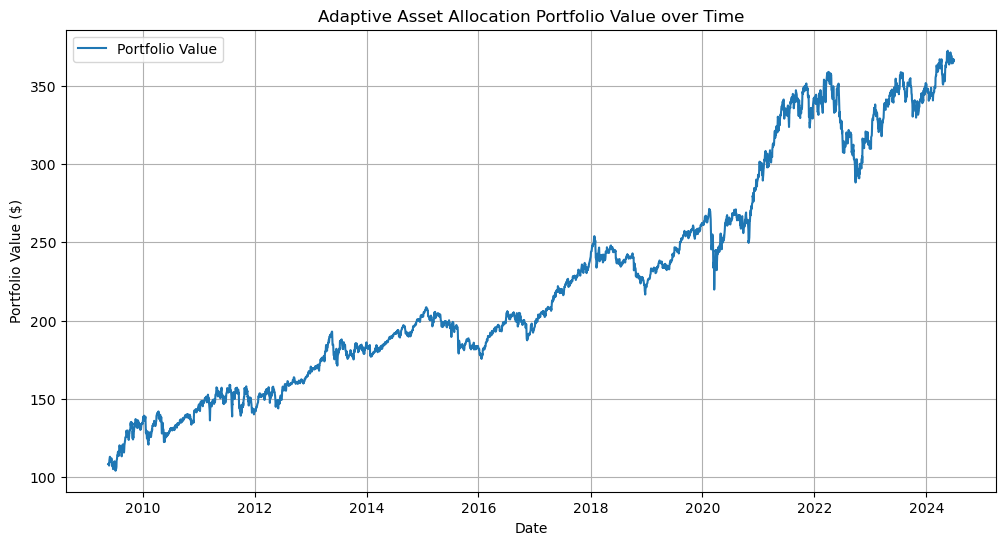

In [10]:
tickers = ['SPY', 'EEM', 'VGK', 'EWJ', 'IEF', 'TLT', 'DBC', 'GLD', 'VNQ', 'RWX']


start_date = '2007-01-01'
data = yf.download(tickers, start=start_date)['Adj Close']

monthly_data = data.resample('M').last()
monthly_returns = monthly_data.pct_change().dropna()

def calculate_trailing_returns(data, window=6):
    return data.pct_change(periods=window).dropna()

def calculate_volatility(data, window):
    return data.pct_change().rolling(window=window).std()

trailing_returns_6m = calculate_trailing_returns(monthly_data, window=6)
volatility_1m = calculate_volatility(monthly_returns, window=21)


trailing_returns_6m = trailing_returns_6m.reindex(monthly_data.index)
volatility_1m = volatility_1m.reindex(monthly_data.index)

allocations = pd.DataFrame(index=monthly_data.index, columns=monthly_data.columns)

for date in allocations.index:
    if pd.isna(trailing_returns_6m.loc[date]).all() or pd.isna(volatility_1m.loc[date]).all():
        continue
    
    top_assets = trailing_returns_6m.loc[date].nlargest(5).index
    inv_vol = 1 / volatility_1m.loc[date, top_assets]
    weights = inv_vol / inv_vol.sum()
    allocations.loc[date, top_assets] = weights


allocations = allocations.fillna(0.0)
portfolio_allocations_filled = allocations.reindex(data.index, method='ffill').fillna(0.0)

daily_returns = data.pct_change().dropna()

weighted_returns = daily_returns * portfolio_allocations_filled
portfolio_returns = weighted_returns.sum(axis=1)

initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[600:], label='Portfolio Value')
plt.title('Adaptive Asset Allocation Portfolio Value over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


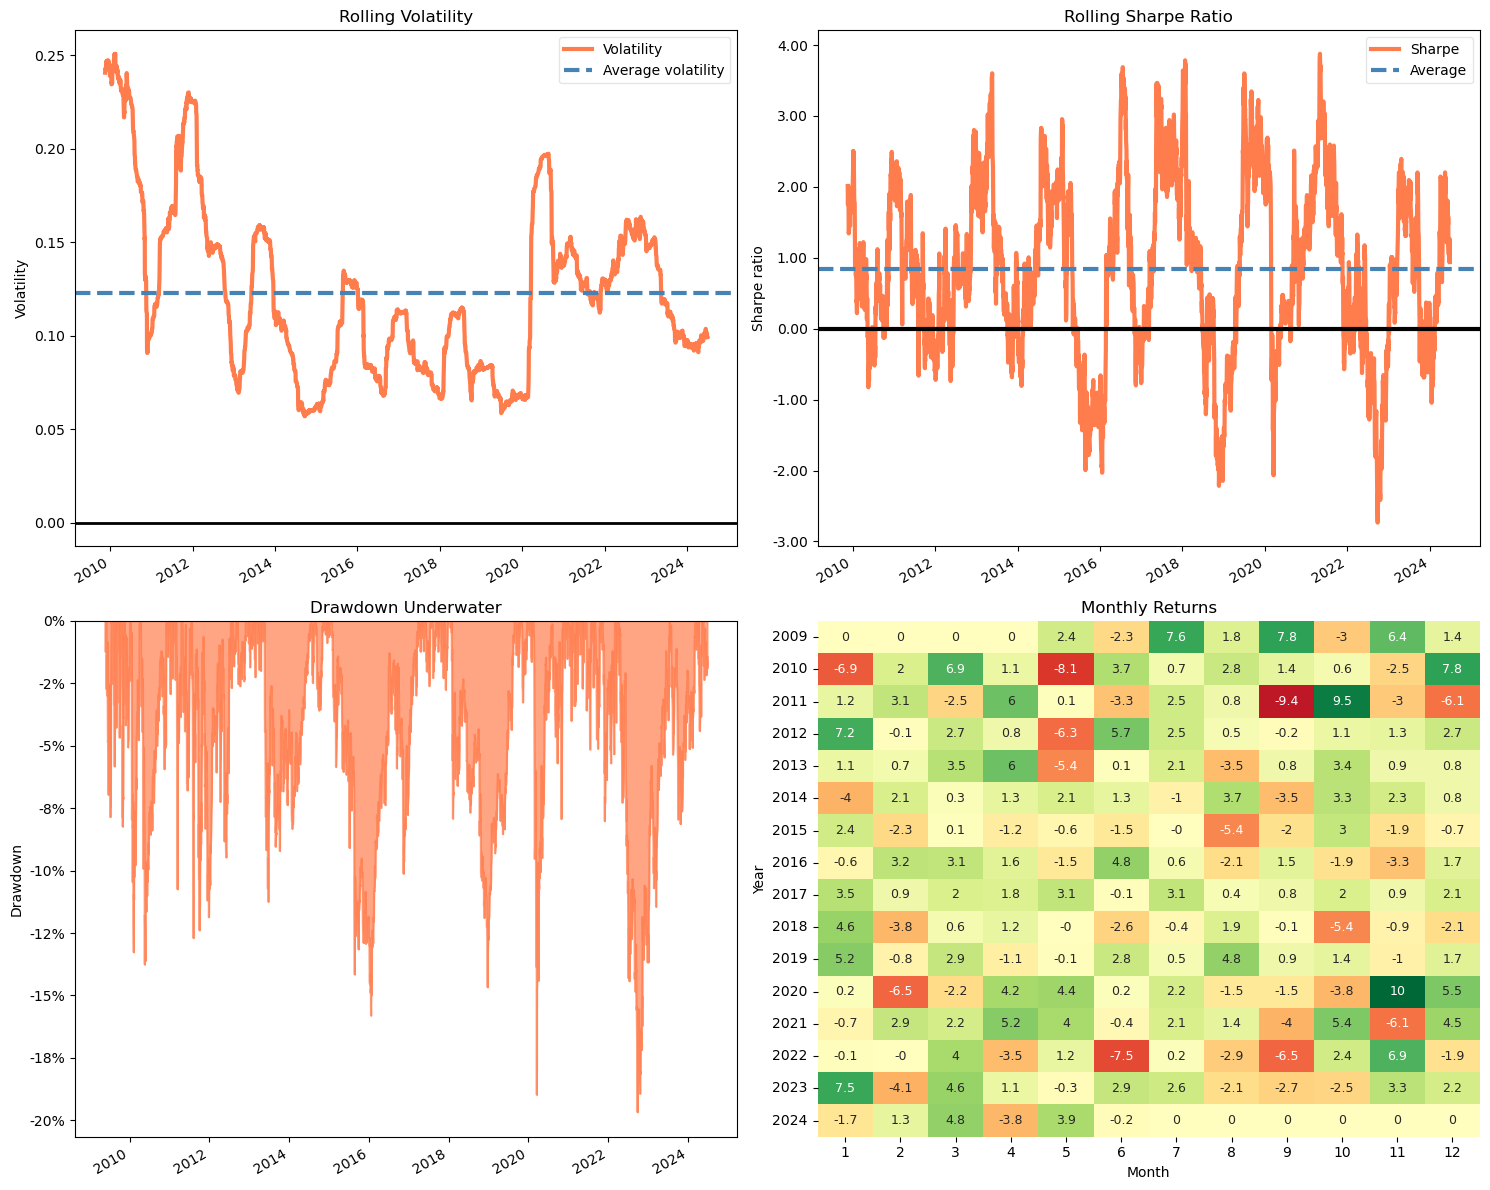

Annual return          0.084069
Cumulative returns     2.377841
Annual volatility      0.132789
Sharpe ratio           0.674456
Calmar ratio           0.427239
Stability              0.962980
Max drawdown          -0.196774
Omega ratio            1.128400
Sortino ratio          0.947789
Skew                  -0.253080
Kurtosis               4.371295
Tail ratio             0.962998
Daily value at risk   -0.016374
dtype: float64


/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [11]:
strategy_returns = portfolio_value[600:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)